## Exploring possible correlation between vulnerability publish date and commit frequency

In [1]:
import pandas as pd
import datetime as dt
from pandas.io.json import json_normalize

Read in GitHub commit data.

In [2]:
commits = pd.read_csv('../../ipynb/data/revision_cleaned.csv', usecols=[1,2,3], parse_dates=['date'])
commits.columns = ['id', 'commit_date', 'message']
print(commits.head())

                                         id         commit_date  \
0  01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b 2015-04-02 01:11:50   
1  01d76a45b817be788eab3e27a93e41c74a6d8957 2010-08-14 17:15:31   
2  03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c 2013-09-27 17:02:55   
3  05c9110ba2615d42af41a77138bc62dd18278320 2011-10-25 20:11:52   
4  06de8d8e88d5b6311ea3feae369c85d157c9dfe3 2017-10-31 20:29:21   

                                             message  
0  Implement dask.array.take\n\nIn principle, we ...  
1                               Convert to spaces.\n  
2  Merge pull request #4887 from cpcloud/groupby-...  
3  Merge pull request #162 from gabrielhurley/use...  
4  Update patch set 1\n\nPatch Set 1: Presubmit-V...  


The two functions below reads in all the NVD data, cleans and extracts the appropriate columns, and returns the data as a single dataframe.

In [3]:
import glob

def import_nvd():
    path = '../../ipynb/data/nvd/'
    all_nvds = glob.glob(path+'*.json')
    l = []
    
    for filename in all_nvds:
        nvd_df = pd.read_json(filename)
        nvd_df = clean_nvd(nvd_df)
        l.append(nvd_df)
    
    return pd.concat(l, ignore_index=True)

def clean_nvd(df):
    df = json_normalize(df['CVE_Items'])
    df = df[['cve.CVE_data_meta.ID', 'publishedDate', 'impact.baseMetricV2.cvssV2.baseScore']]
    df.columns = ['cve_id', 'published_date', 'base_score']
    df['published_date'] = df['published_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%MZ'))
    df = df[(df['published_date'] >= '2005-07-07') & (df['published_date'] < '2018-10-01')]
    
    return df

In [4]:
vulns = import_nvd()
print(vulns.head())

          cve_id      published_date  base_score
0  CVE-2017-0001 2017-03-17 00:59:00         7.2
1  CVE-2017-0002 2017-01-10 21:59:00         6.8
2  CVE-2017-0003 2017-01-10 21:59:00         9.3
3  CVE-2017-0004 2017-01-10 21:59:00         7.8
4  CVE-2017-0005 2017-03-17 00:59:00         6.9


New software vulnerabilities discovered each year.

In [5]:
vulns['published_date'].value_counts().resample('y').apply('count')

2005-12-31     264
2006-12-31     828
2007-12-31     807
2008-12-31     670
2009-12-31     667
2010-12-31     471
2011-12-31     414
2012-12-31     653
2013-12-31     692
2014-12-31     870
2015-12-31     758
2016-12-31     650
2017-12-31    1832
2018-12-31    1896
Freq: A-DEC, Name: published_date, dtype: int64

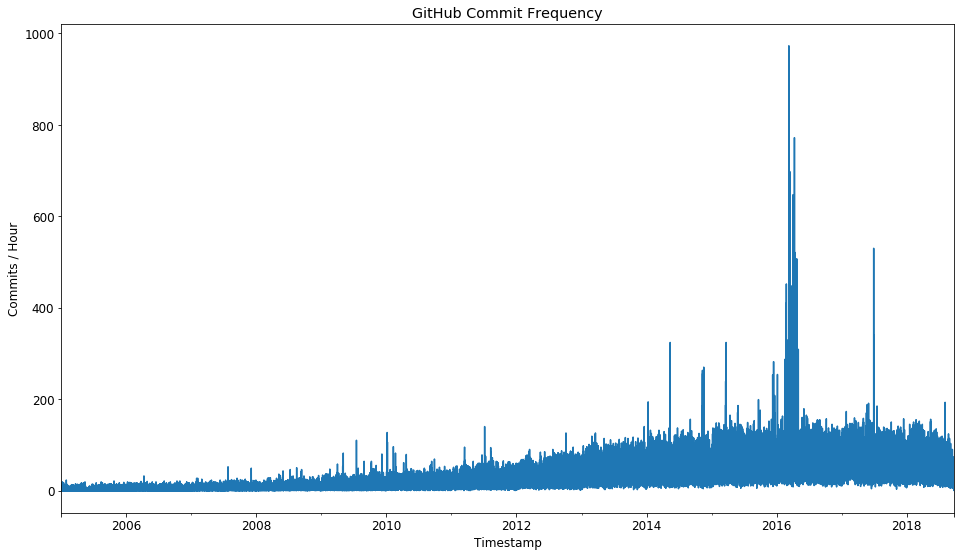

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams.update({'font.size': 12})

commits_h = commits[((commits['commit_date'] != '2017-05-23') | (commits['commit_date'] != '2017-10-23')) & (commits['commit_date'] >= '2005-01-01') & (commits['commit_date'] < '2018-10-01')]['commit_date'].value_counts().resample('h').apply('count')
commits_h.plot()
plt.title('GitHub Commit Frequency')
plt.ylabel('Commits / Hour')
plt.xlabel('Timestamp')
plt.show()

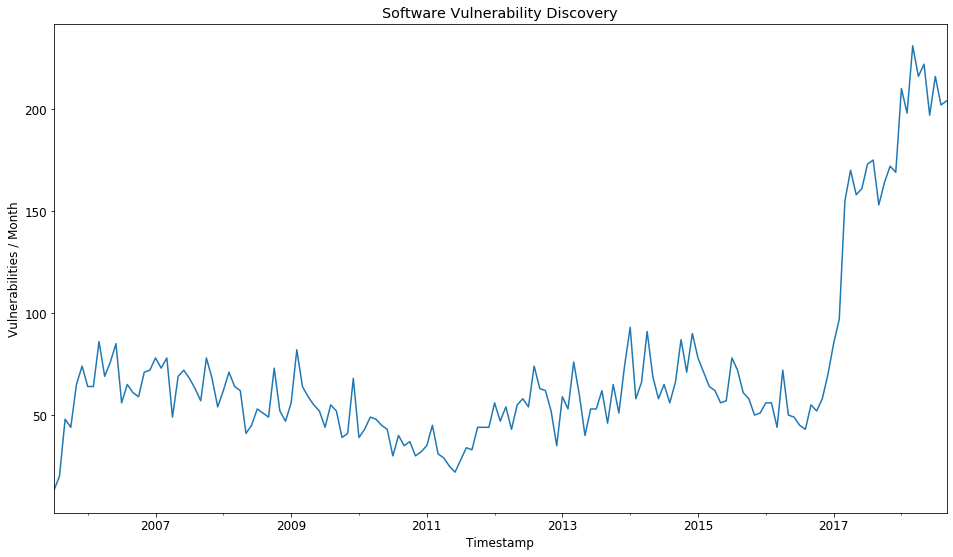

In [8]:
vulns_m = vulns['published_date'].value_counts().resample('m').apply('count')
vulns_m.plot()
plt.title('Software Vulnerability Discovery')
plt.ylabel('Vulnerabilities / Month')
plt.xlabel('Timestamp')
plt.show()

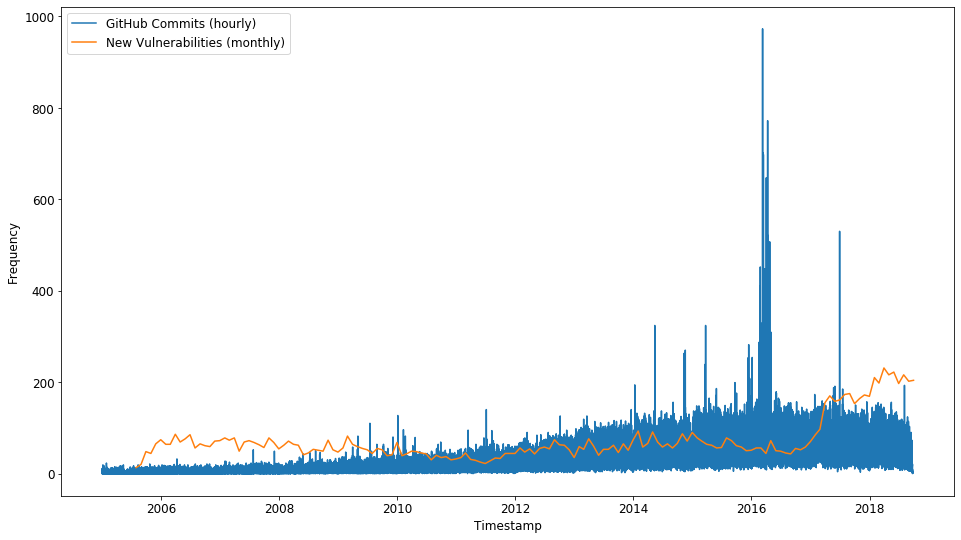

In [9]:
plt.plot(commits_h, label='GitHub Commits (hourly)')
plt.plot(vulns_m, label='New Vulnerabilities (monthly)')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()